In [48]:
import unicodecsv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
from scipy.stats import norm
pd.options.display.float_format = '{:.0f}'.format

In [49]:
import time
import matplotlib.pyplot as plt 
import os 
import seaborn as sns
import pandas as pd

In [3]:
df = pd.read_csv('merged.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18505725 entries, 0 to 18505724
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 

# Pre-processing

1) Remove Flight Delay Reasons Columns, "Unnamed: 27", "CANCELLED" & "CANCELLATION_CODE" column. <br>
2) Remove Cancelled Flight Rows <br>
3) Create Flight Delay columns (0 = punctual, 1 = Delay) <br>
4) Remove diverted flights. <br>
5) Remove rows with "NAN" values in "ACTUAL_ELAPSED_TIME" and "AIR_TIME	" <br>
6) DateTime data manipulation. <br>
7) Proper Data type casting <br>

### 1) Remove Flight Delay Reasons Columns, "Unnamed: 27", "CANCELLED" & "CANCELLATION_CODE" column.

In [5]:
df = df.drop(['Unnamed: 27','CANCELLATION_CODE'],axis=1)

### 2) Remove Cancelled Flight Rows, then drop 'CANCELLED' column.

In [6]:
df = df[df.CANCELLED != 1]
df = df.drop(['CANCELLED'],axis=1)

### 4) Remove diverted flights.

In [7]:
df = df[df.DIVERTED != 1]
df = df.drop(['DIVERTED'],axis=1)

### 5) Remove rows with "NAN" values in "ACTUAL_ELAPSED_TIME" and "AIR_TIME	"

In [8]:
df = df.dropna(subset = ['ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

In [9]:
df.isna().sum().sum()

74258009

### 6) DateTime data manipulation.

In [10]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
# create a new column - Month variable
df['FL_DATE_month'] = pd.to_datetime(df['FL_DATE']).dt.month
df['FL_DATE_year'] = pd.to_datetime(df['FL_DATE']).dt.year
df['FL_DATE_DAY'] = pd.to_datetime(df['FL_DATE']).dt.dayofweek
df = df.drop(['FL_DATE'],axis=1)

In [11]:
df.dtypes

OP_CARRIER              object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
FL_DATE_month            int64
FL_DATE_year             int64
FL_DATE_DAY              int64
dtype: object

# 7) Cast As categorical

In [12]:
df['OP_CARRIER'] = df['OP_CARRIER'].astype('category')
df['ORIGIN'] = df['ORIGIN'].astype('category')
df['DEST'] = df['DEST'].astype('category')

In [13]:
df.isna().sum().sum()

74258009

# Imputation

There are NAN values in "DEP_DELAY" and "ARR_DELAY" columns. We can imputate the data by calculating "DEP_DELAY" and "ARR_DELAY" by :
   * DEP_DELAY = CRS_DEP_TIME - DEP_TIME
   * ARR_DELAY = CRS_ARR_TIME - ARR_TIME

In [14]:
df['DEP_DELAY'] = df.DEP_DELAY.fillna(df.CRS_DEP_TIME - df.DEP_TIME)
df['ARR_DELAY'] = df.ARR_DELAY.fillna(df.CRS_ARR_TIME - df.ARR_TIME)

In [15]:
df['CARRIER_DELAY'] =df['CARRIER_DELAY'].fillna(0)
df['WEATHER_DELAY'] =df['WEATHER_DELAY'].fillna(0)
df['NAS_DELAY'] = df['NAS_DELAY'].fillna(0)
df['SECURITY_DELAY'] = df['SECURITY_DELAY'].fillna(0)
df['LATE_AIRCRAFT_DELAY'] = df['LATE_AIRCRAFT_DELAY'].fillna(0)

In [16]:
print('After imputating the columns, null values in the dataset now is', df.isna().sum().sum())

After imputating the columns, null values in the dataset now is 0


# Feature Selection <br>
1) Drop non-meaningful Columns <br>
2) Remove non-correlated/ highly correlated columns <br>

### DROP Non-Meaningful Columns

Dropping Unwanted data </n>
OP_CARRIER_FL_NUM: Flight number is not useful
FL_DATE: we already have data of month and day column
ARR_TIME & DEPTIME: DEPARTURE_DELAY AND ARRIVAL_DELAY is more useful as they directly provide the delays in minutes.

In [17]:
df = df.drop(['OP_CARRIER_FL_NUM'],axis=1)

### Identify Correlation Between Numerical Attributes

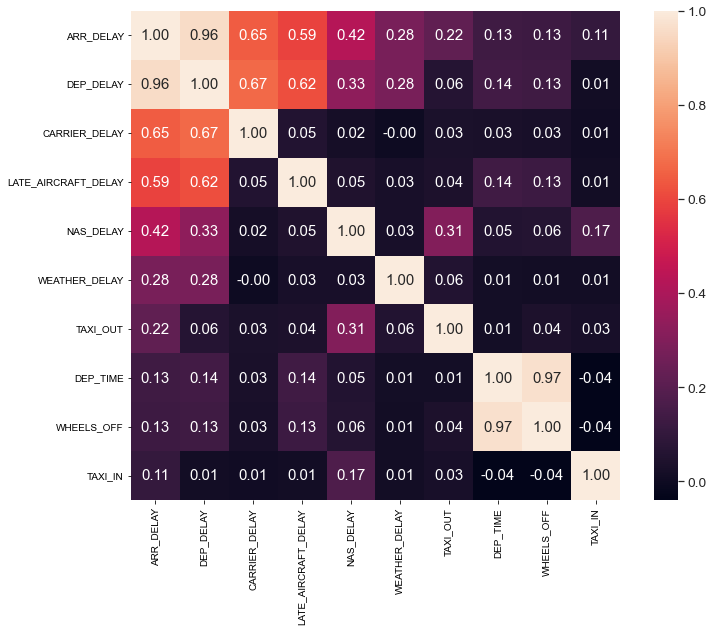

In [18]:
delcorrmat = df.corr()
k = 10 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))
cols = delcorrmat.nlargest(k, 'ARR_DELAY')['ARR_DELAY'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [25]:
# drop uncorrelated numeric features (threshold <0.2)
corr = abs(df.corr().loc['ARR_DELAY'])
corr_higher = corr[(corr<0.2)]
cols_to_drop = corr_higher.index.to_list()
cols_to_drop

['CRS_DEP_TIME',
 'DEP_TIME',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'SECURITY_DELAY',
 'FL_DATE_month',
 'FL_DATE_year',
 'FL_DATE_DAY']

In [30]:
df.drop(cols_to_drop,axis=1,inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18196559 entries, 0 to 18505724
Data columns (total 10 columns):
 #   Column               Dtype   
---  ------               -----   
 0   OP_CARRIER           category
 1   ORIGIN               category
 2   DEST                 category
 3   DEP_DELAY            float64 
 4   TAXI_OUT             float64 
 5   ARR_DELAY            float64 
 6   CARRIER_DELAY        float64 
 7   WEATHER_DELAY        float64 
 8   NAS_DELAY            float64 
 9   LATE_AIRCRAFT_DELAY  float64 
dtypes: category(3), float64(7)
memory usage: 1.2 GB


Dep_time and Wheels off time is highly correlated to each other. Drop Wheel_off as taxi out has higher correlation with the target variable

# Create new column - "DELAY"

Create a new column in the dataframe for delayed flights (1 = delayed, 0 = on time)

In [34]:
delay = []
for row in df['ARR_DELAY']:
        if row <= 0:    delay.append('0')
        elif row > 0 :   delay.append('1')
df['Delay'] = delay
df['Delay'] = df['Delay'].astype('category')

In [40]:
df.drop(['ARR_DELAY'],axis=1,inplace=True)

# Encode Categorical Data

In [35]:
cat_columns = df.select_dtypes(['category']).columns

In [36]:
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

# Check if the data distribution is balance

0    11851178
1     6345381
Name: Delay, dtype: int64


<AxesSubplot:ylabel='Delay'>

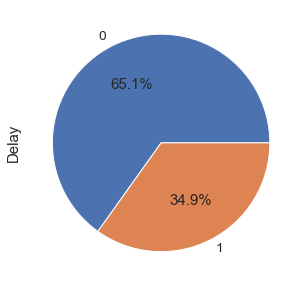

In [37]:
print(df["Delay"].value_counts())
df["Delay"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(5,5))

# Feature Scaling for Numerical Variable

In [42]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

In [43]:
df['DEP_DELAY'] = mms.fit_transform(df[['DEP_DELAY']])
df['TAXI_OUT'] = mms.fit_transform(df[['TAXI_OUT']])
df['CARRIER_DELAY'] = mms.fit_transform(df[['CARRIER_DELAY']])
df['WEATHER_DELAY'] = mms.fit_transform(df[['WEATHER_DELAY']])
df['NAS_DELAY'] = mms.fit_transform(df[['NAS_DELAY']])
df['LATE_AIRCRAFT_DELAY'] = mms.fit_transform(df[['LATE_AIRCRAFT_DELAY']])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18196559 entries, 0 to 18505724
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   OP_CARRIER           int8   
 1   ORIGIN               int16  
 2   DEST                 int16  
 3   DEP_DELAY            float64
 4   TAXI_OUT             float64
 5   CARRIER_DELAY        float64
 6   WEATHER_DELAY        float64
 7   NAS_DELAY            float64
 8   LATE_AIRCRAFT_DELAY  float64
 9   Delay                int8   
dtypes: float64(6), int16(2), int8(2)
memory usage: 1.1 GB


In [46]:
df.to_csv('model_data1.csv',index=False)

In [50]:
df.drop(['DEP_DELAY'],axis=1,inplace=True)

In [51]:
df.to_csv('model_data2.csv',index=False)